In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Download and extract the dataset
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fid = drive.ListFile({'q':"title='Image_Dataset.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('Image_Dataset.zip')
f.keys()
!unzip Image_Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: _train/car/car_0437.jpg  
  inflating: _train/car/car_0438.jpg  
  inflating: _train/car/car_0439.jpg  
  inflating: _train/car/car_0440.jpg  
  inflating: _train/car/car_0441.jpg  
  inflating: _train/car/car_0442.jpg  
  inflating: _train/car/car_0443.jpg  
  inflating: _train/car/car_0444.jpg  
  inflating: _train/car/car_0445.jpg  
  inflating: _train/car/car_0446.jpg  
  inflating: _train/car/car_0447.jpg  
  inflating: _train/car/car_0448.jpg  
  inflating: _train/car/car_0449.jpg  
  inflating: _train/car/car_0450.jpg  
  inflating: _train/car/car_0451.jpg  
  inflating: _train/car/car_0452.jpg  
  inflating: _train/car/car_0453.jpg  
  inflating: _train/car/car_0454.jpg  
  inflating: _train/car/car_0455.jpg  
  inflating: _train/car/car_0456.jpg  
  inflating: _train/car/car_0457.jpg  
  inflating: _train/car/car_0458.jpg  
  inflating: _train/car/car_0459.jpg  
  inflating: _train/car/car_0460.jpg  
  inflating: 

In [3]:
# Define constants
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
NO_CLASSES = 8

In [5]:
# Create data generators for preprocessing
train_datagen = ImageDataGenerator(
    rescale = 1/255,
    horizontal_flip = True,
    rotation_range = 30,
    brightness_range=[0.2,1.0],
    zoom_range=[0.5,1.0]
)
validation_datagen = ImageDataGenerator(
    rescale = 1/255,
    horizontal_flip = True,
    rotation_range = 30,
    brightness_range=[0.2,1.0],
    zoom_range=[0.5,1.0]
)

In [6]:
# Load the data
train_dataset = train_datagen.flow_from_directory(
    '/content/_train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True
)

validation_dataset = validation_datagen.flow_from_directory(
    '/content/_test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)

Found 5959 images belonging to 8 classes.
Found 940 images belonging to 8 classes.


In [7]:
class_names = train_dataset.class_indices.keys()
print(class_names)

dict_keys(['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person'])


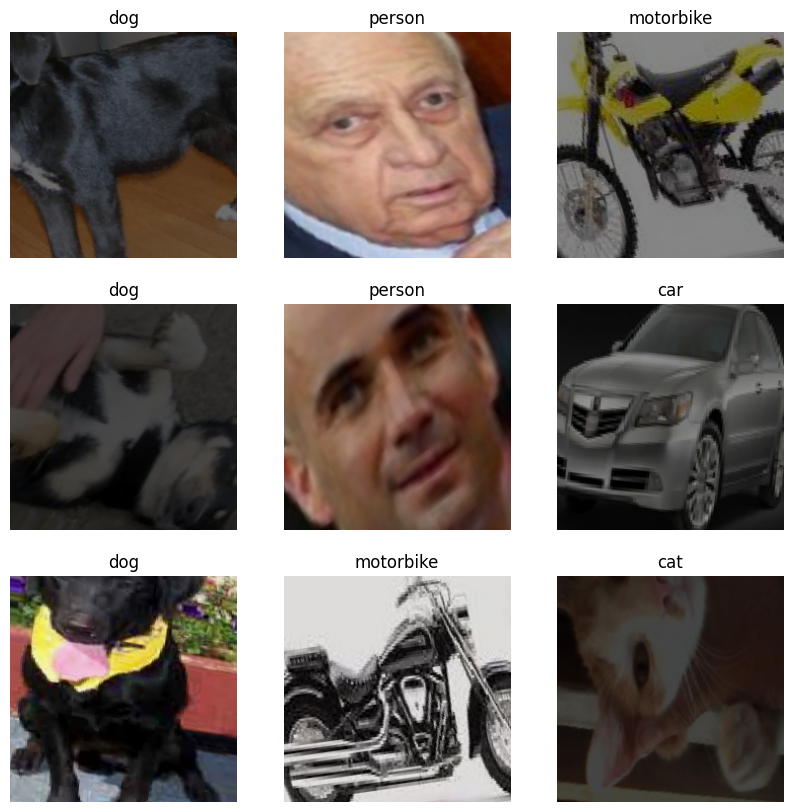

In [8]:
# Plot some images from the training dataset
import matplotlib.pyplot as plt

batch = next(train_dataset)
images = batch[0]
labels = batch[1]
class_names = list(train_dataset.class_indices.keys())

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

plt.show()

In [9]:
# Define the model architecture
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.RandomContrast(0.2)(inputs)
x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(NO_CLASSES, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 random_contrast (RandomCont  (None, 224, 224, 3)      0         
 rast)                                                           
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0     

In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(
    train_dataset,
    epochs=25,
    validation_data=validation_dataset,
)

Epoch 1/25
187/187 [==============================] - 378s 2s/step - loss: 0.3333 - accuracy: 0.8817 - val_loss: 0.2968 - val_accuracy: 0.8979
Epoch 2/25
187/187 [==============================] - 365s 2s/step - loss: 0.3167 - accuracy: 0.8862 - val_loss: 0.3305 - val_accuracy: 0.8734
Epoch 3/25
187/187 [==============================] - 386s 2s/step - loss: 0.3205 - accuracy: 0.8884 - val_loss: 0.3133 - val_accuracy: 0.8926
Epoch 4/25
187/187 [==============================] - 385s 2s/step - loss: 0.3208 - accuracy: 0.8867 - val_loss: 0.2965 - val_accuracy: 0.8915
Epoch 5/25
187/187 [==============================] - 358s 2s/step - loss: 0.3415 - accuracy: 0.8758 - val_loss: 0.3814 - val_accuracy: 0.8564
Epoch 6/25
187/187 [==============================] - 357s 2s/step - loss: 0.3163 - accuracy: 0.8879 - val_loss: 0.3111 - val_accuracy: 0.8915
Epoch 7/25
187/187 [==============================] - 377s 2s/step - loss: 0.2915 - accuracy: 0.8941 - val_loss: 0.2961 - val_accuracy: 0.8840

Saving 339241031_772893594235432_6111340666027967635_n.jpg to 339241031_772893594235432_6111340666027967635_n.jpg


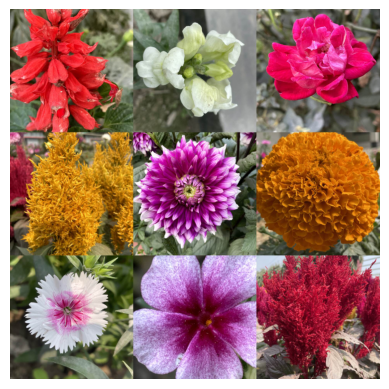

1/1 [==============================] - 0s 30ms/step
The predicted class is: flower


In [15]:
#Testing by userinput image
import IPython.display as display
from PIL import Image
import io
from google.colab import files
from tensorflow import keras


# Prompt the user to upload an image file
uploaded_file = files.upload()

# Load the image using Pillow
img = Image.open(io.BytesIO(uploaded_file[next(iter(uploaded_file))]))

# Display the uploaded image
plt.imshow(img)
plt.axis('off')
plt.show()

# Save the image to the content folder
img.save('uploaded_image.jpg')

# Load the image from the content folder
img = keras.preprocessing.image.load_img(
    'uploaded_image.jpg', target_size=(224, 224)
)

# Convert the image to a numpy array
img_array = keras.preprocessing.image.img_to_array(img)

# Expand the dimensions of the image to match the input shape of the model
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image
img_array = keras.applications.resnet50.preprocess_input(img_array)

# Make a prediction using the model
predictions = model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(predictions, axis=1)[0]

# Get the predicted class name
predicted_class_name = class_names[predicted_class_index]

# Print the predicted class name
print("The predicted class is:", predicted_class_name)
